In [1]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from PIL import Image
import natsort
import glob

In [2]:
import numpy as np
import random

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt 

In [5]:
import tqdm
from torch.utils.tensorboard import SummaryWriter

# DATA IMPORT FROM GOOGLE DRIVE

In [6]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import img_preprocess as img_pp

In [ ]:
import zipfile

def unzip_files(dir_index = [5, 6, 7, 8]):

  for i in dir_index:
    path_to_zip_file = f"/content/drive/MyDrive/data_part_{i}.zip"
    os.makedirs(f'/content/drive/MyDrive/unzipped_data/data_part_{i}')
    
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(f"/content/drive/MyDrive/unzipped_data/data_part_{i}")

In [ ]:
def delete_files_in_dir():

  for i in range(100, 204):
    path = f"/content/drive/MyDrive/{i}"

    for file in os.listdir(path):
      os.remove(os.path.join(path, file))

In [ ]:
#os.mkdir('/content/drive/MyDrive/imgs_set')

In [ ]:
import shutil

def move_files(from_folder, to_folder_path):
  
  image_files = sorted(glob.glob(os.path.join(from_folder, '**', '*.jpg'),
                                recursive=True))

  for file in image_files:
    dir_name = os.path.basename(os.path.dirname(file))
    file_name = os.path.basename(file)
    shutil.move(file, f"{to_folder_path}/{dir_name}_{file_name}" )

In [ ]:
#os.mkdir('/content/drive/MyDrive/sample_imgs')

In [ ]:
def copy_files(from_folder, to_folder):
  
  image_files = sorted(glob.glob(os.path.join(from_folder, '**', '*.jpg'),
                                recursive=True))

  for file in image_files[0:100]:
    file_name = os.path.basename(file)
    shutil.copyfile(file, f"{to_folder}/{file_name}")

In [ ]:
#from_folder = '/content/drive/MyDrive/imgs_set'
#to_folder = '/content/drive/MyDrive/sample_imgs'
#copy_files(from_folder, to_folder)

In [ ]:
#for i in range(1, 9):

#  from_folder = f'/content/drive/MyDrive/unzipped_data/data_part_{i}'
#  to_folder_path = '/content/drive/MyDrive/imgs_set'
#  move_files(from_folder, to_folder_path)

# DATASET and DATALOADER

In [8]:
class CustomDataSet(Dataset):
    def __init__(self, root_dir, borders_x, borders_y, transform = None):
        self.root_dir = root_dir
        self.transform = transform

        all_imgs = os.listdir(root_dir)
        self.total_imgs = natsort.natsorted(all_imgs) ####
        self.borders_x = borders_x
        self.borders_y = borders_y
        #self.device = device
        
        #self.target = None
        #self.mask = None

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):

        img_loc = os.path.join(self.root_dir, self.total_imgs[idx])
        
        image = Image.open(img_loc)

        if self.transform is not None:
          tensor_image = self.transform(image)
        else:
          raise ValueError 

        image_arr = tensor_image.squeeze().detach().to('cpu').numpy()

        _, mask_image, target = img_pp.img_preprocess(image_arr, self.borders_x[idx], self.borders_y[idx])
     
        mask_tensor = torch.from_numpy(mask_image).unsqueeze(0) #.to(self.device)
        mask_border_tensor = torch.logical_not(mask_tensor)

        no_border_tensor_image = tensor_image*mask_tensor
        target_tensor = tensor_image*mask_border_tensor

        return no_border_tensor_image, mask_border_tensor, target_tensor

In [9]:
imgs_path = '/content/drive/MyDrive/imgs_set'
#imgs_path = '/content/drive/MyDrive/sample_imgs'

In [10]:
image_files = sorted(glob.glob(os.path.join(imgs_path, '**', '*.jpg'),
                               recursive=True))

In [11]:
N = len(image_files)

borders_x = [(random.randint(5,9), random.randint(5,9) ) for i in range(N)]
borders_y = [(random.randint(5,9), random.randint(5,9) ) for i in range(N)] 

In [12]:
im_shape = 90

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resize_transforms = transforms.Compose([
  transforms.Resize(size=im_shape),
  transforms.CenterCrop(size=(im_shape, im_shape)),
  transforms.ToTensor()
  ])

dataset = CustomDataSet(imgs_path, borders_x, borders_y, transform = resize_transforms)

In [ ]:
#dataset.__getitem__(1)
#dataset.__getitem__(1)[0].shape


In [ ]:
#plt.imshow(dataset.__getitem__(1)[0].squeeze(),  cmap='gray')

In [ ]:
#plt.imshow(dataset.__getitem__(1)[0][90:180].squeeze(),  cmap='gray')

In [ ]:
#plt.imshow(dataset.__getitem__(1)[0][0,:90].squeeze(),  cmap='gray')

In [13]:
# Split dataset into training, validation, and test set "randomly"

trainingset = torch.utils.data.Subset(dataset, indices=np.arange(int(len(dataset)*(3/5))))
validationset = torch.utils.data.Subset(dataset, indices=np.arange(int(len(dataset)*(3/5)),
                                                                               int(len(dataset)*(4/5))))
testset = torch.utils.data.Subset(dataset, indices=np.arange(int(len(dataset)*(4/5)),
                                                                         len(dataset)))

In [14]:
trainloader = torch.utils.data.DataLoader(trainingset, batch_size=16, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(validationset, batch_size=16, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=0)

# Model: Simple CNN

In [15]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, n_in_channels: int = 1, n_hidden_layers: int = 3, n_kernels: int = 32, kernel_size: int = 7):
        
        """Simple CNN with `n_hidden_layers`, `n_kernels`, and `kernel_size` as hyperparameters"""
        super(SimpleCNN, self).__init__()
        
        cnn = []

        for i in range(n_hidden_layers):
            cnn.append(torch.nn.Conv2d(in_channels=n_in_channels, out_channels=n_kernels, kernel_size=kernel_size,
                                       bias=True, padding=int(kernel_size/2)))
            cnn.append(torch.nn.ReLU())
            n_in_channels = n_kernels

        self.hidden_layers = torch.nn.Sequential(*cnn)
        self.output_layer = torch.nn.Conv2d(in_channels=n_in_channels, out_channels=1,
                                            kernel_size=kernel_size, bias=True, padding=int(kernel_size/2))
    
    def forward(self, x):
        """Apply CNN to input `x` of shape (N, n_channels, X, Y), where N=n_samples and X, Y are spatial dimensions"""
        cnn_out = self.hidden_layers(x)  # apply hidden layers (N, n_in_channels, X, Y) -> (N, n_kernels, X, Y)
        pred = self.output_layer(cnn_out)  # apply output layer (N, n_kernels, X, Y) -> (N, 1, X, Y)
        return pred

In [16]:
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (hidden_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
  )
  (output_layer): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)

In [18]:
#model = torch.load('/content/drive/MyDrive/best_model3.pt')
#model.to(device)

In [19]:
mse = torch.nn.MSELoss()

In [20]:
learningrate = 1e-5 #1e-3
weight_decay = 1e-7

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=learningrate, weight_decay=weight_decay)

#Training the model

In [22]:
root_dir = "/content/drive/MyDrive"
writer = SummaryWriter(log_dir=os.path.join(root_dir, 'tensorboard'))
best_validation_loss = np.inf #infinity

In [ ]:
def evaluate_model(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device):
    """Function for evaluation of a model `model` on the data in `dataloader` on device `device`"""
    # Define a loss (mse loss)
    mse = torch.nn.MSELoss()
    # We will accumulate the mean loss in variable `loss`
    loss = torch.tensor(0., device=device)
    
    with torch.no_grad():  # We do not need gradients for evaluation
        # Loop over all samples in `dataloader`
        for data in tqdm.tqdm(dataloader, desc=f"scoring", position=0):
            # Get a sample and move inputs and targets to device
            inputs, b_masks, targets = data
            inputs = inputs.to(device).squeeze(0)
            b_masks = b_masks.to(device)
            targets = targets.to(device)
            
            # Get outputs for network
            outputs = model(inputs)
            
            # Here we could clamp the outputs to the minimum and maximum values of inputs for better performance
            
            # Calculate mean mse loss over all samples in dataloader (accumulate mean losses in `loss`)

            loss += (torch.stack([mse(output*b_masks[i], target) for i, (output, target) in enumerate(zip(outputs, targets))]).sum()
                     / len(dataloader.dataset))

    return loss

In [34]:
update = 0
validate_at = 20
print_stats_at = 1
n_updates = 10
validate_ = True

update_progess_bar = tqdm.tqdm(total=n_updates, desc=f"loss: {np.nan:7.5f}", position=0);

# Train until n_updates update have been reached
while update < n_updates:
    for data in trainloader:
        inputs, b_masks, targets = data
        inputs = inputs.to(device).squeeze(0)
        b_masks = b_masks.to(device)
        targets = targets.to(device)
            
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Get outputs for network
        outputs = model(inputs)
        
        # Calculate loss, do backward pass, and update weights
        #loss = mse(outputs[0]*torch.logical_not(inputs[1]), targets)

        loss = mse(outputs*b_masks, targets)
        
        loss.backward()
        optimizer.step()
        
        # Print current status and score
        if update % print_stats_at == 0 and update > 0:
            writer.add_scalar(tag="training/loss",
                              scalar_value=loss.cpu(), # covert to cpu ??
                              global_step=update)
        
        # Plot output
        #if update % plot_at == 0:
        #    plot(inputs.detach().cpu().numpy(), targets.detach().cpu().numpy(), outputs.detach().cpu().numpy(),
        #          plotpath, update)
        
        # define plotpath


        # Evaluate model on validation set
        if update % validate_at == 0 and update > 0 and validate_:
            val_loss = evaluate_model(model, dataloader=valloader, device=device)
            writer.add_scalar(tag="validation/loss", scalar_value=val_loss.cpu(), global_step=update)
            # Add weights as arrays to tensorboard
            for i, param in enumerate(model.parameters()):
                writer.add_histogram(tag=f'validation/param_{i}', values=param.cpu(),
                                      global_step=update)
            # Add gradients as arrays to tensorboard
            for i, param in enumerate(model.parameters()):
                writer.add_histogram(tag=f'validation/gradients_{i}',
                                      values=param.grad.cpu(),
                                     global_step=update)
            # Save best model for early stopping
            if best_validation_loss > val_loss:
                best_validation_loss = val_loss
                torch.save(model, os.path.join(root_dir, 'best_model.pt'))
        
        update_progess_bar.set_description(f"loss: {loss:7.5f}", refresh=True)
        update_progess_bar.update()
        
        # Increment update counter, exit if maximum number of updates is reached
        update += 1
        if update >= n_updates:
            break

update_progess_bar.close()

print('')
print('Finished Training!')

loss: 0.00813: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


Finished Training!


In [ ]:
# Load best model and compute score on test set
print(f"Computing scores for best model")

model = torch.load('/content/drive/MyDrive/best_model3.pt').to(device)
#test_loss = evaluate_model(model, dataloader=testloader, device=device)
val_loss = evaluate_model(model, dataloader=valloader, device=device)
#train_loss = evaluate_model(model, dataloader=trainloader, device=device)

print(f"Scores:")
print(f"test loss: {test_loss}")
print(f"validation loss: {val_loss}")
print(f"training loss: {train_loss}")

Computing scores for best model


scoring: loss     nan: 100%|██████████| 1297/1297 [20:18<00:00,  1.06it/s]

Scores:
test loss: 0.005914564710110426
validation loss: 0.006046063266694546
training loss: 0.005498535465449095


In [ ]:
# best model 3
#test loss: 0.005914564710110426
#validation loss: 0.006046063266694546
#training loss: 0.005498535465449095

#Hyperparameter optimization

In [ ]:
#!pip install -U skorch

In [ ]:
from skorch import NeuralNet
import skorch

In [ ]:
model = torch.load('/content/drive/MyDrive/best_model3.pt').to(device)

In [ ]:
net = NeuralNet(
    model,
    max_epochs=200,
    criterion = torch.nn.MSELoss,
    lr=0.01,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    device = device,
    optimizer = torch.optim.Adam,
    train_split = None
)

In [ ]:
for data in trainloader:
        inputs, b_masks, targets = data
        inputs = inputs.to(device).squeeze(0)
        b_masks = b_masks.to(device)
        targets = targets.to(device)

        X = inputs
        y = targets

        net.fit(X, y)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0039  1.6049
      2   390962.0312  1.5992
      3       67.2796  1.5925
      4        0.0917  1.5800
      5        0.1100  1.5955
      6        0.1148  1.5824
      7        0.0803  1.5896
      8        0.0577  1.5899
      9        0.0630  1.5723
     10        0.0337  1.5947
     11        0.0408  1.5790
     12        0.0387  1.5831
     13        0.0310  1.6003
     14        0.0319  1.5965
     15        0.0383  1.5961
     16        0.0313  1.5812
     17        0.0283  1.6017
     18        0.0311  1.5856
     19        0.0328  1.5821
     20        0.0311  1.5762
     21        0.0280  1.5860
     22        0.0279  1.5848
     23        0.0294  1.5921
     24        0.0281  1.5687
     25        0.0270  1.5827
     26        0.0279  1.5923
     27        0.0284  1.5922
     28        0.0272  1.6088
     29        0.0256  1.5766
     30        0.0256  1.5981
     31        0.0265  1.5889
     32   

In [23]:
for data in trainloader:
        inputs, b_masks, targets = data
        inputs = inputs.to(device).squeeze(0)
        b_masks = b_masks.to(device)
        targets = targets.to(device)

        X = inputs
        image = net.predict(X)

        plt.figure()

        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(inputs[0].squeeze() + image[0].squeeze(),  cmap='gray')
        ax[1].imshow(image[0].squeeze(),  cmap='gray')


NameError: ignored

In [ ]:
#batch = next(iter(data_loader))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
class MyNet(NeuralNet):

  def score(self, X, y=None):
      return mean_squared_error(self, X, y)
      

In [ ]:
net = MyNet(
    model,
    max_epochs=10,
    criterion = torch.nn.MSELoss,
    lr=learningrate,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    device = device,
    optimizer = torch.optim.Adam,
    train_split = None
)

In [ ]:
param_grid = {'lr': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}
              #'n_hidden_layers': [3, 4, 5],
              #'kernel_size': [3, 7],
              #'n_kernels': [32, 64]}

In [ ]:
gs = GridSearchCV(net, param_grid, refit = False)

In [ ]:
net.get_params().keys()

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 'verbose', 'device', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__name', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__valid_loss', 'callbacks__valid_loss__name', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__print_log', 'callbacks__print_log__keys_ignored', 'callbacks__print_log__sink', 'callbacks__print_log__tablefmt', 'callbacks__print_log__floatfmt', 'callbacks__print_log__stralign'])

In [ ]:
data_singleBatch = next(iter(trainloader))

In [ ]:
data_singleBatch = next(iter(trainloader))

X, _, y = data_singleBatch
X = X.to(device).squeeze(0)
y = y.to(device)

gs.fit(X, y) 

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0720  0.8896
      2  61734453248.0000  0.8450
      3   225760.3594  0.8368
      4        0.2563  0.8551
      5        0.0952  0.8522
      6        0.1127  0.8575
      7        0.1303  0.8439
      8        0.1477  0.8465
      9        0.1644  0.8437
     10        0.0662  0.8537


TypeError: ignored

In [ ]:
gs.best_score_, gs.best_params_ 

(nan, {'lr': 0.1})

#Debug

In [ ]:
# DIMENSION input debug

#img = trainloader.dataset.__getitem__(2)
#model.forward(img[0]).shape

In [ ]:
#IMG, MASK = dataset.__getitem__(0)[0]

In [ ]:
#IMG

In [ ]:
# test model

#img___ = dataset.__getitem__(1)[0][0]
#mask___ = dataset.__getitem__(1)[0][1]
#plt.imshow(img___.squeeze(),  cmap='gray')
#outputs = model(inputs)

In [ ]:
#plt.imshow(outputs[3,0, 0:90].detach().numpy(),  cmap='gray')

In [35]:
for i, data in enumerate(trainloader):
  if(i < 1):
      inputs, b_mask, targets = data
      
      inputs = inputs.to(device).squeeze(0)
      b_masks = b_masks.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
  else:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

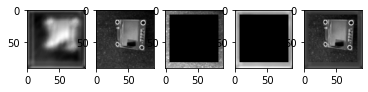

<Figure size 432x288 with 0 Axes>

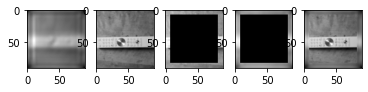

<Figure size 432x288 with 0 Axes>

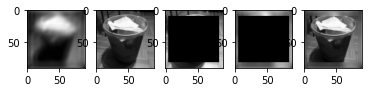

<Figure size 432x288 with 0 Axes>

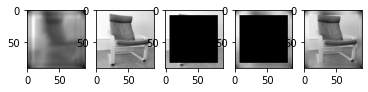

<Figure size 432x288 with 0 Axes>

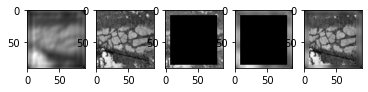

<Figure size 432x288 with 0 Axes>

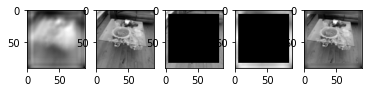

<Figure size 432x288 with 0 Axes>

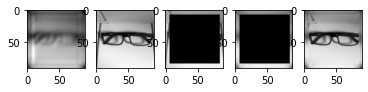

<Figure size 432x288 with 0 Axes>

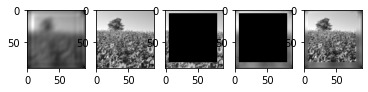

<Figure size 432x288 with 0 Axes>

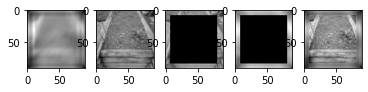

<Figure size 432x288 with 0 Axes>

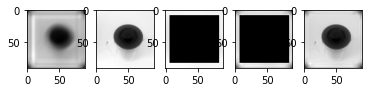

<Figure size 432x288 with 0 Axes>

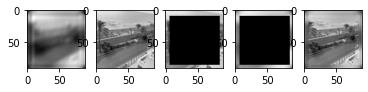

<Figure size 432x288 with 0 Axes>

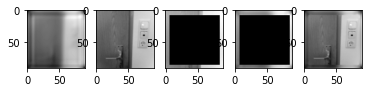

<Figure size 432x288 with 0 Axes>

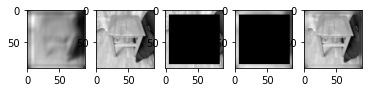

<Figure size 432x288 with 0 Axes>

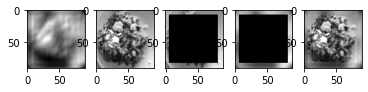

<Figure size 432x288 with 0 Axes>

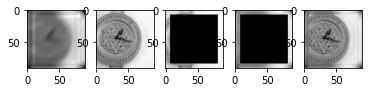

<Figure size 432x288 with 0 Axes>

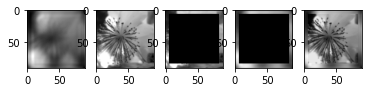

In [50]:
for i, output in enumerate(outputs):
    plt.figure()

    fig, ax = plt.subplots(1, 5)

    merged_image = inputs[i] + targets[i]
    predicted_target = output.cuda()*b_mask[i].cuda()

    merged_with_prediction = inputs[i] + predicted_target

    ax[0].imshow(output.squeeze().detach().cpu().numpy(),  cmap='gray')
    ax[1].imshow(merged_image.squeeze().detach().cpu().numpy(),  cmap='gray')
    ax[2].imshow(targets[i].squeeze().detach().cpu().numpy(),  cmap='gray')
    ax[3].imshow(predicted_target.squeeze().detach().cpu().numpy(),  cmap='gray')
    ax[4].imshow(merged_with_prediction.squeeze().detach().cpu().numpy(),  cmap='gray')

In [ ]:
#plt.imshow(outputs[1].squeeze().detach().numpy(),  cmap='gray')

In [ ]:
#plt.imshow(outputs[0].squeeze().detach().numpy(),  cmap='gray')

In [ ]:
#plt.imshow((outputs[0]*outputs[1]).squeeze().detach().numpy(),  cmap='gray')

In [ ]:
#mask = dataset.__getitem__(1)[1]
#plt.imshow((outputs[0]*mask).squeeze().detach().numpy(),  cmap='gray')

In [ ]:
#target = IMG[torch.logical_not(MASK)]
#plt.imshow((IMG*torch.logical_not(MASK)).squeeze(),  cmap='gray')

NameError: ignored

In [ ]:
for data in trainloader:
    inputs, targets = data
    inputs = inputs.to(device).squeeze(0)
    targets = targets.to(device)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Get outputs for network
    outputs = model(inputs.to('cpu')).to('cuda')

In [ ]:
outputs[:,:, 0:90].shape

torch.Size([32, 1, 90, 90])

In [66]:
for i, data in enumerate(trainloader):
      inputs, mask, targets = data
      inputs = inputs #.squeeze(0)
      targets = targets


      if(i < 2):

        print('inputs', inputs.shape)
        outputs = model(inputs)

        #print('out', outputs[0][0,:90].squeeze().shape)
        print('out', outputs[:,:, 0:90])

      if(i > 2):
        break

inputs torch.Size([16, 1, 90, 90])


RuntimeError: ignored

In [ ]:
#dataset.__getitem__(1)

data = dataset.__getitem__(1)

#plt.imshow(data[0][1].squeeze(),  cmap='gray')

#invert toTensor operation
#print ((data[0]*255 )[0])

# Testing for submission

In [111]:
from matplotlib import cm

In [76]:
data_sub.keys()

dict_keys(['input_arrays', 'known_arrays', 'borders_x', 'borders_y', 'sample_ids'])

In [60]:
input_test = torch.from_numpy(data_sub['input_arrays'][0])
input_test = input_test.to(device)

In [119]:
class SubmissionDataSet(Dataset):
    
    def __init__(self, pickle_file, transform = None):

        data_sub = pd.read_pickle(pickle_file)
        self.total_imgs = [image for image in data_sub['input_arrays']]
        self.mask = [mask_ for mask_ in data_sub['known_arrays']]
        self.transform = transform

    def __len__(self):
        return len(self.total_imgs)


    def __getitem__(self, idx):

        im_array = self.total_imgs[idx]
        mask_array = self.mask[idx]

        im_PIL = Image.fromarray(np.uint8(im_array)) #.convert('RGB')
        mask_PIL = Image.fromarray(np.uint8(mask_array)) #.convert('RGB')

        if self.transform is not None:
          image_tensor = self.transform(im_PIL)
          mask_tensor = self.transform(mask_PIL)

        else:
          raise ValueError 
        
        #mask_border_tensor = torch.logical_not(mask_tensor)
        #no_border_tensor_image = tensor_image*mask_tensor

        return image_tensor, mask_tensor

In [123]:
toTensor_transforms = transforms.Compose([
  transforms.ToTensor()
  ])

In [124]:
filepath = '/content/drive/MyDrive/testset.pkl'
sub_dataset = SubmissionDataSet(filepath, transform = toTensor_transforms)

In [125]:
sub_loader = torch.utils.data.DataLoader(sub_dataset, batch_size=32, shuffle=False, num_workers=0)

In [127]:
for i, data in enumerate(sub_loader):

      if(i == 0):

        inputs, mask = data
        print(inputs[0].unsqueeze(0).shape)

torch.Size([1, 1, 90, 90])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

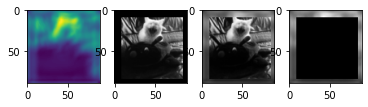

<Figure size 432x288 with 0 Axes>

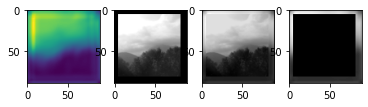

<Figure size 432x288 with 0 Axes>

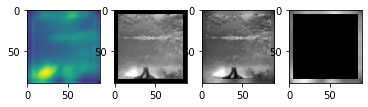

<Figure size 432x288 with 0 Axes>

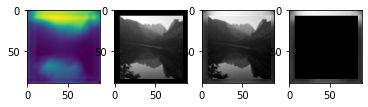

<Figure size 432x288 with 0 Axes>

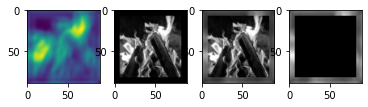

<Figure size 432x288 with 0 Axes>

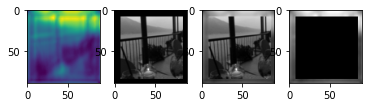

<Figure size 432x288 with 0 Axes>

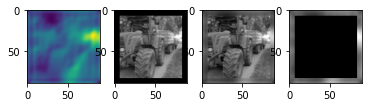

<Figure size 432x288 with 0 Axes>

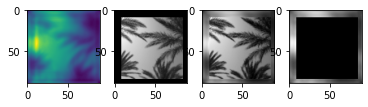

<Figure size 432x288 with 0 Axes>

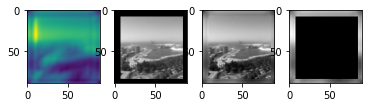

<Figure size 432x288 with 0 Axes>

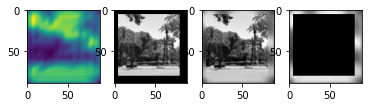

<Figure size 432x288 with 0 Axes>

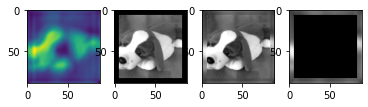

<Figure size 432x288 with 0 Axes>

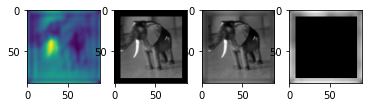

<Figure size 432x288 with 0 Axes>

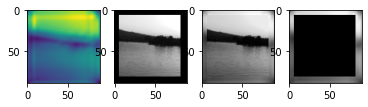

<Figure size 432x288 with 0 Axes>

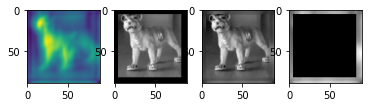

<Figure size 432x288 with 0 Axes>

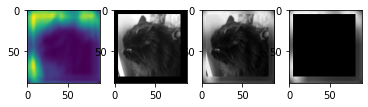

<Figure size 432x288 with 0 Axes>

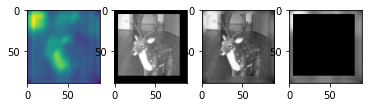

<Figure size 432x288 with 0 Axes>

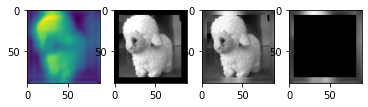

<Figure size 432x288 with 0 Axes>

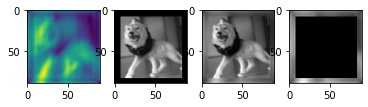

<Figure size 432x288 with 0 Axes>

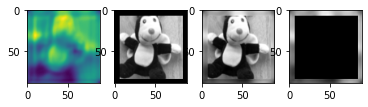

<Figure size 432x288 with 0 Axes>

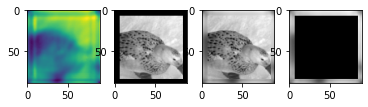

<Figure size 432x288 with 0 Axes>

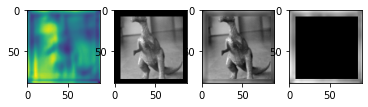

<Figure size 432x288 with 0 Axes>

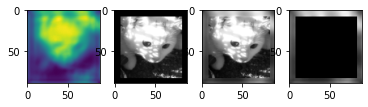

<Figure size 432x288 with 0 Axes>

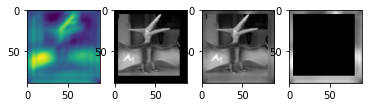

<Figure size 432x288 with 0 Axes>

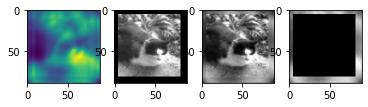

<Figure size 432x288 with 0 Axes>

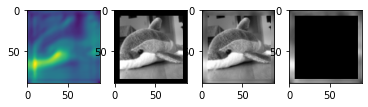

<Figure size 432x288 with 0 Axes>

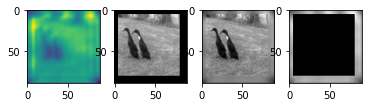

<Figure size 432x288 with 0 Axes>

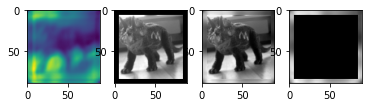

<Figure size 432x288 with 0 Axes>

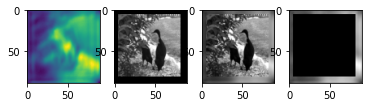

<Figure size 432x288 with 0 Axes>

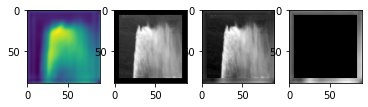

<Figure size 432x288 with 0 Axes>

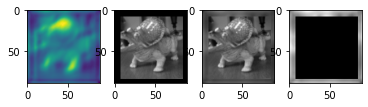

<Figure size 432x288 with 0 Axes>

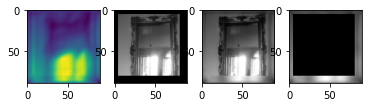

<Figure size 432x288 with 0 Axes>

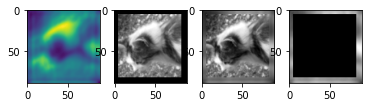

In [190]:
for i, data in enumerate(sub_loader):

      if(i == 0):

        inputs, mask = data
        
        inputs = inputs.to(device)
        mask = torch.logical_not(mask).to(device)

        outputs = model(inputs)

        for i, output in enumerate(outputs):
          
          plt.figure()

          fig, ax = plt.subplots(1, 4)

          correction = output.squeeze()*mask[i] + inputs[i]
          target = mask[i]*output.squeeze()

          #ax[0].imshow(output.squeeze().detach().cpu().numpy(),  cmap='gray')

          ax[0].imshow((output.squeeze().detach().cpu().numpy()*255).astype(int))
          ax[1].imshow(inputs[i].squeeze().detach().cpu().numpy(),  cmap='gray')
          ax[2].imshow(correction.squeeze().detach().cpu().numpy(),  cmap='gray')
          ax[3].imshow(target.squeeze().detach().cpu().numpy(),  cmap='gray')

      else:
        break

In [202]:
pd.read_pickle('/content/drive/MyDrive/testset_submission_random.pkl')

[array([172,  10, 127, ..., 143,  91,  94], dtype=uint8),
 array([ 83,   3,  22, ..., 135, 100, 136], dtype=uint8),
 array([180,  76,   7, ..., 198,  57, 236], dtype=uint8),
 array([194, 164, 175, ...,  40, 140, 125], dtype=uint8),
 array([241,  52,  84, ...,  13, 135, 194], dtype=uint8),
 array([ 91, 119, 113, ...,   8, 112, 159], dtype=uint8),
 array([145, 176, 141, ..., 133,  98,  87], dtype=uint8),
 array([ 83, 246, 249, ...,  74, 151, 182], dtype=uint8),
 array([169, 197,  24, ..., 215, 158, 255], dtype=uint8),
 array([ 79,  90,  55, ..., 100,  16,  33], dtype=uint8),
 array([ 69, 157, 131, ..., 144, 187,   9], dtype=uint8),
 array([229, 213,  95, ...,  90, 137, 220], dtype=uint8),
 array([166, 167,  36, ...,  29, 130,  34], dtype=uint8),
 array([218, 223,  61, ..., 170, 224, 213], dtype=uint8),
 array([193, 241,  80, ...,  49, 236, 215], dtype=uint8),
 array([  1, 114,  66, ...,  70,  37, 108], dtype=uint8),
 array([235,  32, 206, ..., 107,  85, 169], dtype=uint8),
 array([100, 1

In [141]:
images = []

In [185]:
test_images = []
mask_images = []

for i, data in enumerate(sub_loader):

        inputs, mask = data
        
        inputs = inputs.to(device)
        mask = torch.logical_not(mask).to(device)

        outputs = model(inputs)

        for i, output in enumerate(outputs):

          target = mask[i]*output.squeeze()

          # convert maschera a array
          # coverto output ad array
          # output[mask].flatten()

          test_images.append(target.squeeze().detach().cpu().numpy())
          mask_images.append(mask[i].squeeze().detach().cpu().numpy())

In [193]:
final_list = []

for i, im in enumerate(test_images):
  final_list.append(np.uint8(im[mask_images[i]]*255))

In [204]:
import pickle

In [207]:
with open('/content/drive/MyDrive/first_try.pkl','wb') as f:
  pickle.dump(final_list, f)

In [208]:
pd.read_pickle('/content/drive/MyDrive/first_try.pkl')

[array([46, 54, 64, ..., 49, 42, 38], dtype=uint8),
 array([101, 122, 151, ...,  54,  45,  40], dtype=uint8),
 array([51, 59, 71, ..., 63, 52, 47], dtype=uint8),
 array([57, 71, 89, ..., 47, 39, 36], dtype=uint8),
 array([45, 52, 61, ..., 59, 49, 43], dtype=uint8),
 array([50, 60, 72, ..., 51, 43, 39], dtype=uint8),
 array([49, 57, 69, ..., 70, 57, 49], dtype=uint8),
 array([47, 56, 68, ..., 53, 44, 39], dtype=uint8),
 array([51, 61, 74, ..., 70, 58, 51], dtype=uint8),
 array([ 82,  96, 118, ...,  59,  48,  42], dtype=uint8),
 array([48, 55, 64, ..., 67, 55, 48], dtype=uint8),
 array([46, 53, 63, ..., 67, 55, 47], dtype=uint8),
 array([ 77,  94, 116, ...,  62,  50,  43], dtype=uint8),
 array([45, 51, 60, ..., 63, 51, 45], dtype=uint8),
 array([ 98, 117, 145, ...,  54,  45,  40], dtype=uint8),
 array([ 91, 110, 136, ...,  56,  46,  41], dtype=uint8),
 array([48, 55, 64, ..., 56, 47, 41], dtype=uint8),
 array([48, 57, 68, ..., 65, 53, 46], dtype=uint8),
 array([58, 70, 87, ..., 93, 76, 6

In [220]:
def f(x):

  return + x*((35-0)/(-829.065 + 3227.376)	) + 47.09904595358984


In [221]:
#35: -829.065
# 0: -3227.376	
# giulia: -1534.432

In [228]:
f(-1534.432)


24.706153622278347